In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest

from sklearn.svm import OneClassSVM
import warnings
warnings.filterwarnings("ignore")

In [46]:
df = pd.read_csv('creditcard.csv')

In [47]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Performing some EDA

#### Checking the shape of the data

In [48]:
df.shape

(284807, 31)

#### Checking null values

In [49]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

#### Checking the distribution of normal and fruad cases in our dataset

In [50]:
pd.value_counts(df['Class'], sort = True)

0    284315
1       492
Name: Class, dtype: int64

#### Let us see the shapes of normal and fraud datasets

In [51]:
fraud = df[df['Class']==1]
normal = df[df['Class']==0]
print(f'Fruad:{fraud.shape}')
print(f'Normal:{normal.shape}')

Fruad:(492, 31)
Normal:(284315, 31)


#### Finding out the average amount in both cases

In [52]:
fraud['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [53]:
normal['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

#### Transaction amount for fraud and normal cases

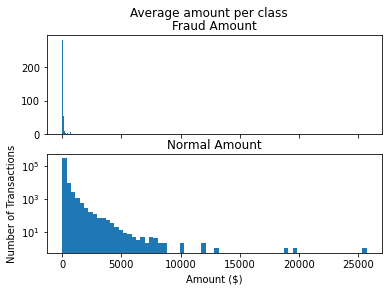

In [54]:
graph, (plot1, plot2) = plt.subplots(2,1,sharex= True)
graph.suptitle('Average amount per class')
bins = 70

plot1.hist(fraud['Amount'] , bins = bins)
plot1.set_title('Fraud Amount')

plot2.hist(normal['Amount'] , bins = bins)
plot2.set_title('Normal Amount')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

We can see that the fraudulent transctions are mostly densed in the lower range of amount, whereas the non-fraudulent transctions are spreaded throughout low to high range of amount.

#### Plotting a correlation heatmap

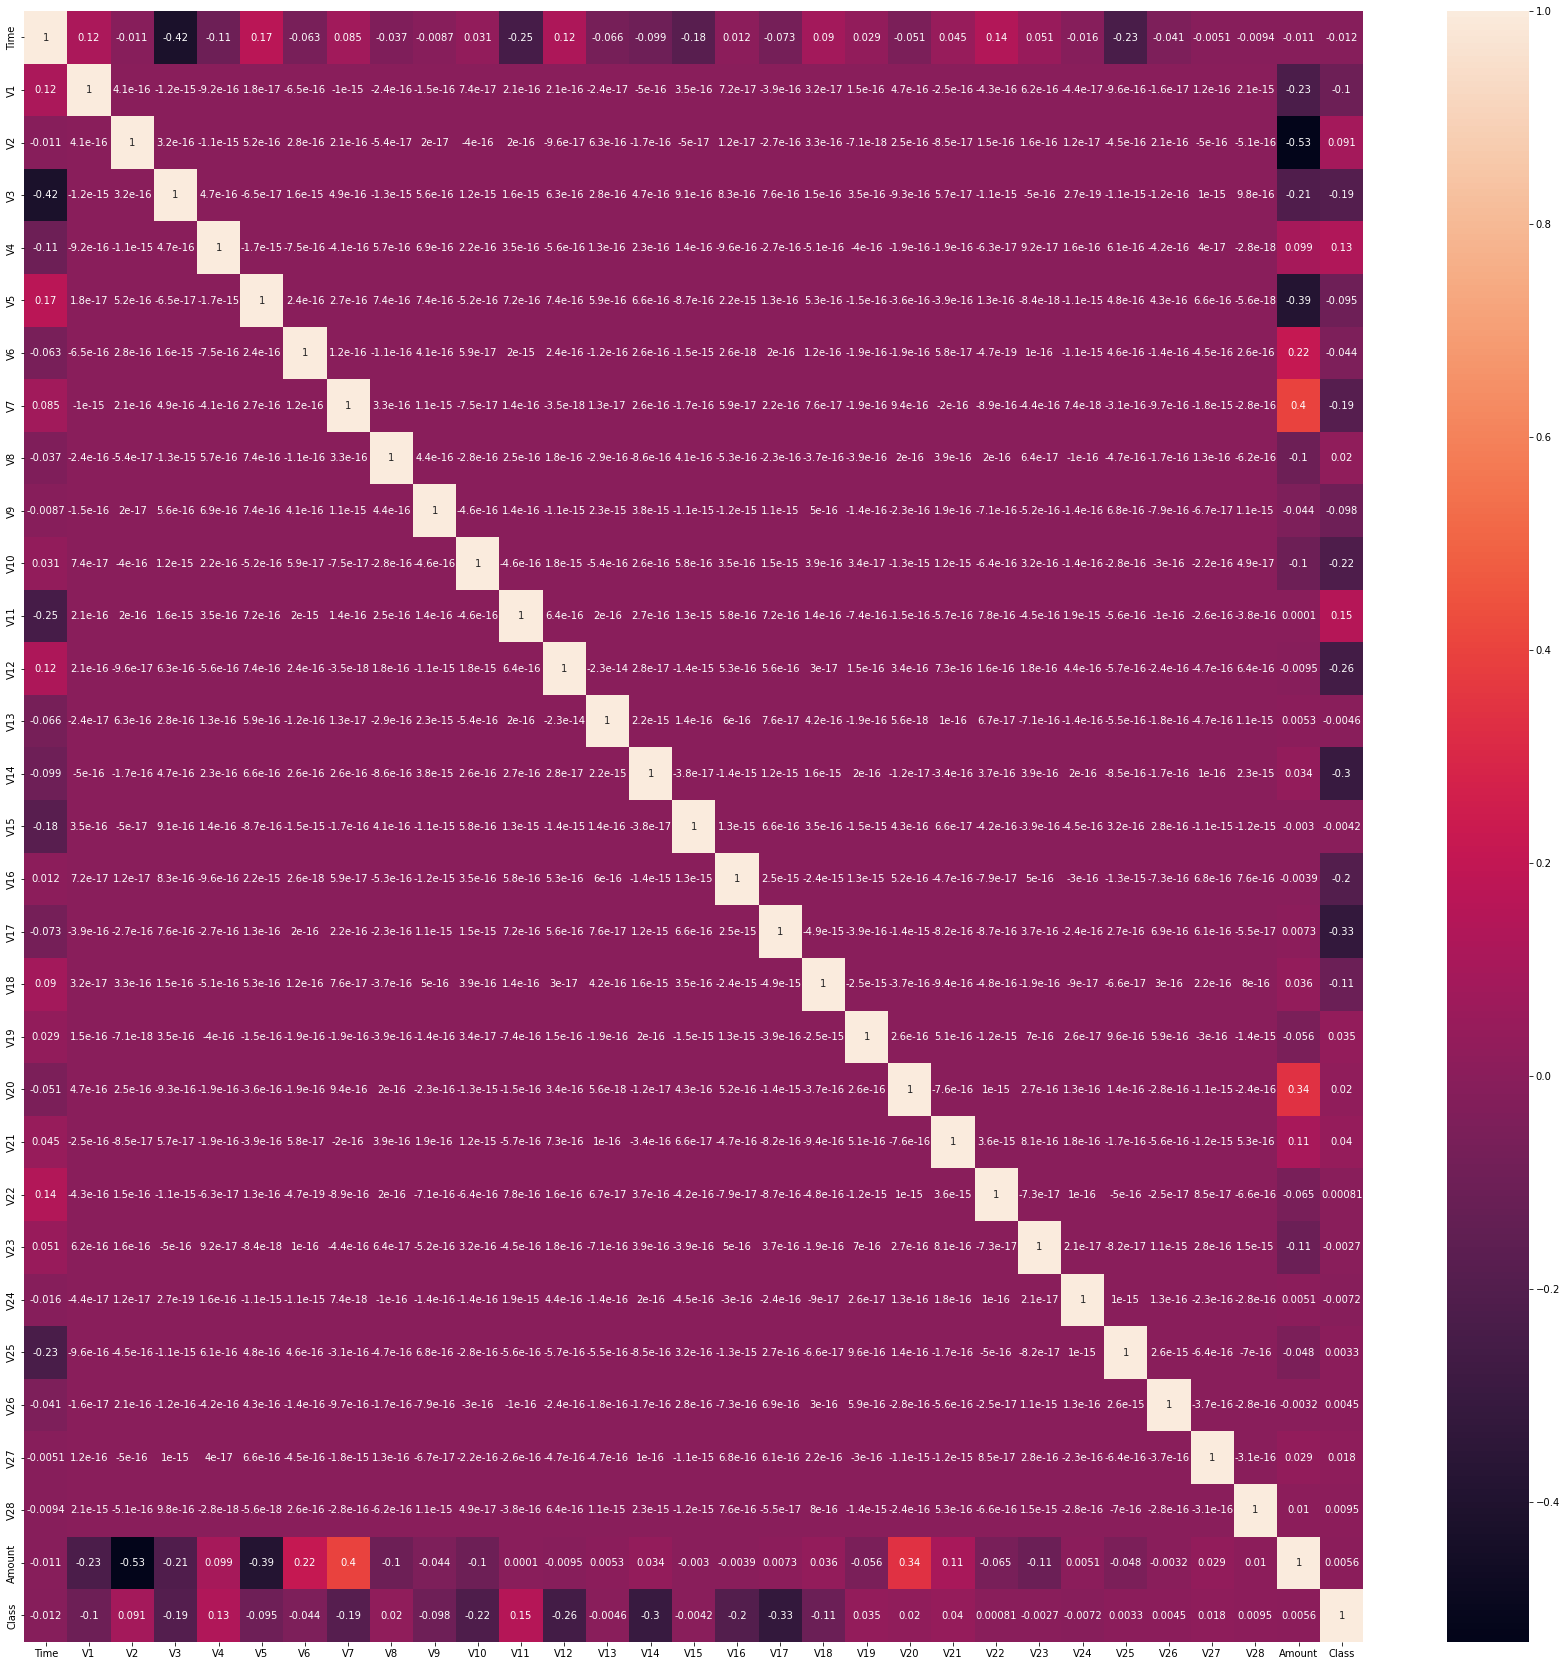

In [34]:
df.corr()
plt.figure(figsize=(30,30))
g=sns.heatmap(df.corr(),annot=True)

#### Observe the distribution of classes with time

In [35]:
# Creating fraudulent dataframe
data_fraud = df[df['Class'] == 1]
# Creating non fraudulent dataframe
data_non_fraud = df[df['Class'] == 0]

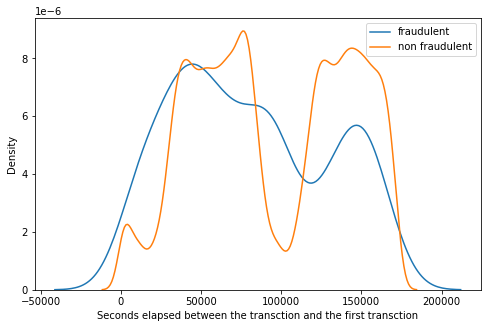

In [36]:
# Distribution plot
plt.figure(figsize=(8,5))
ax = sns.distplot(data_fraud['Time'],label='fraudulent',hist=False)
ax = sns.distplot(data_non_fraud['Time'],label='non fraudulent',hist=False)
plt.legend(['fraudulent','non fraudulent'])
ax.set(xlabel='Seconds elapsed between the transction and the first transction')
plt.show()

We do not see any specific pattern for the fraudulent and non-fraudulent transctions with respect to Time.

#### Creating our dependent & independent features

In [55]:
columns = df.columns.tolist()
# Making our Independent Features
columns = columns[:-1]
# Making our Dependent Variable
target = "Class"
x= df[columns]
y= df[target]

In [56]:
x.shape

(284807, 30)

In [57]:
y.shape

(284807,)

In [58]:
x = df.drop('Class', axis = 1).values
y = df['Class'].values

#### Since the data for fraud cases is low, we use SMOTE

In [59]:
# import library
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE()
# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(x, y)


print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 284315, 1: 492})
Resample dataset shape Counter({0: 284315, 1: 284315})


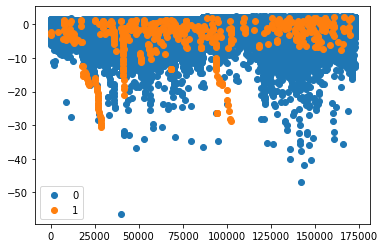

In [60]:
from numpy import where
from matplotlib import pyplot

# scatter plot of examples by class label
for label, _ in Counter(y_smote).items():
	row_ix = where(y == label)[0]
	pyplot.scatter(x[row_ix, 0], x[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

### Model Building

In [68]:
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score,f1_score,classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

In [62]:
# Split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.30, random_state=42)

#### Trying IsolationForest

In [103]:
model = IsolationForest(n_estimators=100, max_samples=len(x_train),random_state=0, verbose=0)
# Increasing n_estimators can increase accuracy

In [104]:
model.fit(x_train,y_train)

IsolationForest(max_samples=398041, random_state=0)

##### Checking predictions on train set

In [120]:
y_train_pred = model.predict(x_train)

In [122]:
y_train_pred[y_train_pred == 1] = 0
y_train_pred[y_train_pred == -1] = 1

In [123]:
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)

[[198779    387]
 [197167   1708]]


In [124]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [125]:
# Accuracy
print("Accuracy:",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:",TP / float(TP+FN))

# Specificity
print("Specificity:", TN / float(TN+FP))

# F1 score
print("F1-Score:", f1_score(y_train, y_train_pred))

Accuracy: 0.5036842938290277
Sensitivity: 0.00858830923947203
Specificity: 0.9980568972615808
F1-Score: 0.01699756182514803


In [126]:
# classification_report
print(classification_report(y_train, y_train_pred))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67    199166
           1       0.82      0.01      0.02    198875

    accuracy                           0.50    398041
   macro avg       0.66      0.50      0.34    398041
weighted avg       0.66      0.50      0.34    398041



##### Checking predictions on test set

In [127]:
y_test_pred = model.predict(x_test)

In [128]:
y_test_pred[y_test_pred == 1] = 0
y_test_pred[y_test_pred == -1] = 1

In [129]:
confusion = confusion_matrix(y_test, y_test_pred)
print(confusion)

[[84995   154]
 [84562   878]]


In [130]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [131]:
# Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:",TP / float(TP+FN))

# Specificity
print("Specificity:", TN / float(TN+FP))

# F1 score
print("F1-Score:", f1_score(y_test, y_test_pred))

Accuracy: 0.503391191694658
Sensitivity: 0.01027621722846442
Specificity: 0.998191405653619
F1-Score: 0.02030715144786752


As we can see the accuracy is around 50% which is very less
Hence we can conclude that IsolationForest is not performing well on the data

#### Trying XGboost

In [90]:
# fit model no training data
model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [91]:
y_train_pred = model.predict(x_train)

In [95]:
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)

[[199166      0]
 [     0 198875]]


In [96]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [97]:
# Accuracy
print("Accuracy:",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:",TP / float(TP+FN))

# Specificity
print("Specificity:", TN / float(TN+FP))

# F1 score
print("F1-Score:", f1_score(y_train, y_train_pred))

Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
F1-Score: 1.0


In [98]:
print(classification_report(y_train, y_train_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199166
           1       1.00      1.00      1.00    198875

    accuracy                           1.00    398041
   macro avg       1.00      1.00      1.00    398041
weighted avg       1.00      1.00      1.00    398041



##### Checking predictions on test 

In [99]:
y_test_pred = model.predict(x_test)

In [100]:
confusion = confusion_matrix(y_test, y_test_pred)
print(confusion)

[[85126    23]
 [    0 85440]]


In [101]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [102]:
# Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:",TP / float(TP+FN))

# Specificity
print("Specificity:", TN / float(TN+FP))

# F1 score
print("F1-Score:", f1_score(y_test, y_test_pred))


Accuracy: 0.9998651730181899
Sensitivity: 1.0
Specificity: 0.9997298852599561
F1-Score: 0.9998654207357389


As we can see the accuracy for XGboost is quite good.

#### Trying decision Tree

In [132]:
from sklearn.tree import DecisionTreeClassifier

In [133]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

DecisionTreeClassifier()

##### Checking predictions on train set

In [134]:
y_train_pred = model.predict(x_train)

In [135]:
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)

[[199166      0]
 [     0 198875]]


In [136]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [137]:
# Accuracy
print("Accuracy:",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:",TP / float(TP+FN))

# Specificity
print("Specificity:", TN / float(TN+FP))

# F1 score
print("F1-Score:", f1_score(y_train, y_train_pred))

Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
F1-Score: 1.0


In [138]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199166
           1       1.00      1.00      1.00    198875

    accuracy                           1.00    398041
   macro avg       1.00      1.00      1.00    398041
weighted avg       1.00      1.00      1.00    398041



##### Checking predictions on test set

In [139]:
y_test_pred = model.predict(x_test)

In [140]:
confusion = confusion_matrix(y_test, y_test_pred)
print(confusion)

[[84898   251]
 [   95 85345]]


In [141]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [142]:
# Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:",TP / float(TP+FN))

# Specificity
print("Specificity:", TN / float(TN+FP))

# F1 score
print("F1-Score:", f1_score(y_test, y_test_pred))

Accuracy: 0.9979717332301614
Sensitivity: 0.9988881086142322
Specificity: 0.9970522260977815
F1-Score: 0.9979770340746977


#### Conclusion

The performance of XGboost and Decision tree was better compared to isolation Forest. XGboost performs slightly better than Decision Tree classifier